## Example Notebook for deployment

This notebook was recreated for the purpose of studying deploying data science modules.  

## Predict survival using logistic regression with sex, age and title

## Introduction

In this notebook, we will go over some typical steps of a data science pipeline in order to predict if a passenger survives the Titanic accident:

* Data loading
* Data cleaning
* Feature engineering
* Predictions
    * Majority classifier (benchmark)
    * Ridge logistic regression
    
Part of this analysis is inspired by the blog article How to score 0.8134 in Titanic Kaggle Challenge.

Note that we are not aiming to achieve a high score, but just to show a data science workflow.

## Import Libraries

In [57]:
# Import libraries
# ----------------

# Pandas
import pandas as pd

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Python operating system module
import os

# ingnore warnings
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [44]:
os.getcwd()

'C:\\Users\\kre8tions\\Documents\\The-Lab\\Classes\\titanic_datascience\\exploration\\Predict passenger survival using ridge logistic regression'

In [45]:
os.chdir('..\data')

In [46]:
raw_data_file = "train.csv"
df = pd.read_csv(raw_data_file, usecols=['Name', 'Sex', 'Age', 'Survived'])
print('DataFrame shape: {}'.format(df.shape))
df.head()

DataFrame shape: (891, 4)


,Survived,Name,Sex,Age
0,0,"Braund, Mr. Owen Harris",male,22.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0
2,1,"Heikkinen, Miss. Laina",female,26.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0
4,0,"Allen, Mr. William Henry",male,35.0


Always store file and directory names into variables and use the os.path functions to manipulate paths. In this case, raw_data_file = "../data/titanic.csv".

## Data Cleaning

In [47]:
# Percentage of missing values in each column
pd.DataFrame(
    df.isnull().sum() / len(df),
    columns=['% Missing Values']
).transpose()

,Survived,Name,Sex,Age
% Missing Values,0.0,0.0,0.0,0.198653


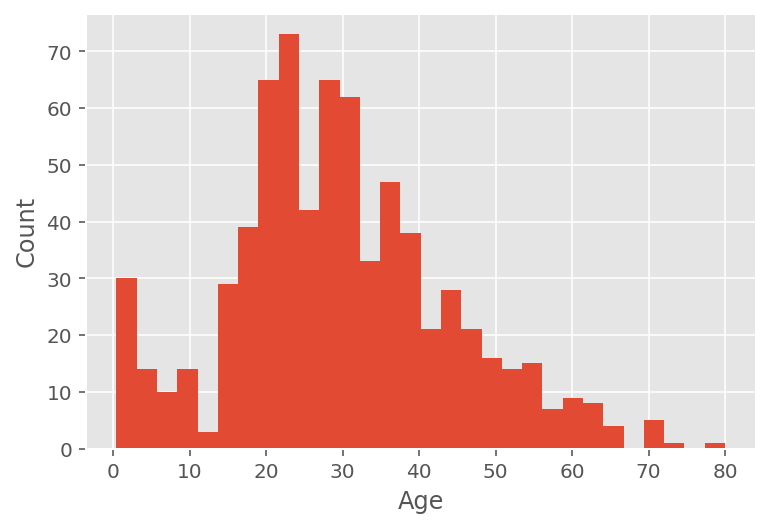

In [48]:
# Age histogram
df.Age.hist(bins=30)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Because the age has a tail for higher values, we choose the median to replace missing values, as the median is more robust than the mean against extreme values.

In [50]:
df = df.fillna({'Age': df.Age.median(), })
df.head()

,Survived,Name,Sex,Age
0,0,"Braund, Mr. Owen Harris",male,22.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0
2,1,"Heikkinen, Miss. Laina",female,26.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0
4,0,"Allen, Mr. William Henry",male,35.0


Now that we don't have any missing values, we can assign a variable type to each column.

In [51]:
df = df.astype({
    'Age': 'float64',
    'Name': 'object',
    'Sex': 'category',
    'Survived': 'int64',
})

## Feature Engineering

The passenger names contain titles which we can use to make predictions under the assumption that more wealthy people we have been given precedence to the emergency boats. However, some of the 18 titles in the data are redundant and can be reduced to 6.

In [52]:
# Extract the Title from the name

simplify_title = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir": "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess": "Royalty",
    "Dona": "Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Royalty"
}

df['Title'] = df['Name'].apply(
    lambda full_name: (
        simplify_title[
            # Example: Uruchurtu, Don. Manuel E --> Don
            full_name.split(',')[1].split('.')[0].strip()
        ]
    )
)

df['Title'] = df['Title'].astype('category')

df.head()

,Survived,Name,Sex,Age,Title
0,0,"Braund, Mr. Owen Harris",male,22.0,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,Mrs
2,1,"Heikkinen, Miss. Laina",female,26.0,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,Mrs
4,0,"Allen, Mr. William Henry",male,35.0,Mr


## Predictions

Having completed the data preprocessing, we prepare the data to run models.

In [53]:
# Select variables
df = df[['Age', 'Sex', 'Title', 'Survived']]

# One-hot encoding of categorical variables
df = pd.get_dummies(df, columns=['Sex', 'Title'])

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Survived', axis=1).values,
    df['Survived'].values,
    test_size=0.2,
    random_state=0
)

First, we start by defining a simple benchmark over which we can improve with a more elaborate model. For the benchmark, we use the majority vote classifier.

In [54]:
# Mjority vote classifier
majority_vote = round(y_train.mean())
y_test_predictions = [majority_vote] * len(y_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_test_predictions)
print('The prediction accuracy with the majority vote classifier is {:.1f}%'.format(accuracy * 100))

The prediction accuracy with the majority vote classifier is 61.5%


Next, we use a ridge logistic regression.

In [58]:
# Ridge logistic regression

lr = LogisticRegression(random_state=0, solver='lbfgs')

param_range = [2 ** x for x in range(-10, 10)]

gs = GridSearchCV(
    estimator=lr,
    param_grid={'C': param_range},
    scoring='accuracy',
    cv=10,
    n_jobs=-1
)

gs.fit(X_train, y_train)

accuracy = accuracy_score(y_true=y_test, y_pred=gs.predict(X_test))

print('The prediction accuracy with the ridge logistic regression classifier is {:.1f}%'.format(accuracy * 100))

The prediction accuracy with the ridge logistic regression classifier is 78.2%


In conclusion, using the sex, age and title of passengers, we fitted a ridge logistic regression model that, for our particular train-test split, predicts if a passenger will survive with about 78.2% accurancy, improving by 16.7% over the 61.5% accuracy of the majority classifier.

In this notebook we went through a basic data science pipeline, where we loaded the data, cleaned it, engineered a feature and made predictions using logistic regression.